### Emotion dataset

**Imports**

In [17]:
# Text preprocessing pipeline
from sklearn.pipeline import Pipeline 
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.feature_extraction.text import TfidfTransformer 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.feature_extraction.text import HashingVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from nltk.corpus import stopwords

# Metrics
from sklearn.metrics import accuracy_score
from sklearn import metrics


# imports 
import numpy as np
import pandas as pd
df = pd.read_excel('Diabetes-classification.xlsx', sheet_name ='Emotions')

In [18]:
# import nltk
# nltk.download('stopwords')

In [30]:
# Preparing dataset
X = df.loc[:,'discussion_text']
y = df.loc[:,'Label']

# removes all duplicates from list 
Labels = list(dict.fromkeys(y)) 
print(Labels)

import re
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()
# Use NLTK's PorterStemmer
def stemming_tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [porter_stemmer.stem(word) for word in words]
    return words


# Preprocess pipeline for texts
# and training configuration 
mystopwords = stopwords.words()
top_k_features=1000
# Pipeline inspiration:
# https://towardsdatascience.com/pipeline-for-text-data-pre-processing-a9887b4e2db3

pipe_clf = Pipeline([
    #('vect', CountVectorizer(decode_error='ignore', stop_words='english')),
    #('vect', CountVectorizer(decode_error='strict', stop_words='english')),

    ('vect', CountVectorizer(stop_words=mystopwords, lowercase=True, tokenizer=stemming_tokenizer)),
    ('chi2score', SelectKBest(chi2, k=top_k_features)),
    ('tfidf', TfidfTransformer(use_idf=True)),

    #('vect', TfidfVectorizer()),
    
    #('vect', TfidfVectorizer(stop_words='english', tokenizer=stemming_tokenizer, use_idf=False, norm='l1')),
    #('scaler', StandardScaler(with_mean=False)),
    #('vect', HashingVectorizer(n_features=2**4)),
    #('tfidf', TfidfTransformer()),
    #('clf', LogisticRegression( penalty='l2', solver='lbfgs', dual=False, multi_class='multinomial', tol=1e-3, max_iter=1000)),
    ('clf', LogisticRegression(multi_class='multinomial', tol=1e-3, fit_intercept=False)),
    #('clf', LogisticRegression( penalty='l2', solver='lbfgs', dual=False, class_weight='balanced', multi_class='multinomial', tol=1e-4)),
])

# possible to get 50-70% accuracy with this dataset 

# Logistic regression parameters:
# - dual: Prefer dual=False when n_samples > n_features
# - tol: Tolerance for stopping criteria.
# - class_weight: dict or ‘balanced’, default=None


['Trust', 'Disgust', 'Anticipation', 'Sadness', 'Anger', 'Fear', 'Joy', 'Surprise']


**Logistic Regression classifier**
- You can use either use scikit-learn or NLTK for building the classifiers.
- test them using part of the labeled dataset as the test set

In [20]:
def get_most_informative_features(clf, vectorizer, 
                                  label_names, 
                                  max_number_informative_features):
    """
    Prints features with the highest coefficient values, per class
    """
    output = []

    
    try:
        feature_names = vectorizer.get_feature_names()

        label_index = len(label_names)
        
        if label_index == 2:
            label_index = 1
            print('features for binary classification!')
        
        for index in range(label_index):
#             print(str(index) + label_names[index])
            #print('clf.coef_:',len(clf.coef_))
            
            # will work nicely only with 2 categories (code {:>30} is just formatting)
#             output.append(f'\n {label_names[index]}: {label_names[index+1]:>30}:')
            output.append('\n' + label_names[index] + ':\n')
            
            #combine feature names with their coefficients
            coefs_with_fns = sorted(zip(clf.coef_[index], feature_names))
            
            #print(coefs_with_fns)
            
            #half for one label, half for the other
            threshold = int(max_number_informative_features / 2)

            top = zip(coefs_with_fns[:threshold],
                      coefs_with_fns[:-(threshold + 1):-1])
            
            for (coef_1, fn_1), (coef_2, fn_2) in top:
                feat = "\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2)
                output.append(feat)
            
            #print('\n'.join(output))
                
    except:
        print("Unexpected error:", sys.exc_info()[0])
        raise 
        return '\n'.join(output)

    return '\n'.join(output)

D:\Program Files\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['-', 'abbiat', 'abov', 'acaba', 'ace', 'aceast', 'ahogi', 'aib', 'alguna', 'alguno', 'altm', 'ame', 'amo', 'anch', 'ani', 'ant', 'anum', 'aquel', 'ara', 'arr', 'art', 'asl', 'ata', 'atar', 'aurion', 'auron', 'avai', 'ave', 'avess', 'avest', 'avet', 'avev', 'avion', 'avon', 'avr', 'avrebb', 'avrest', 'avret', 'ayon', 'azut', 'b', 'bamo', 'ban', 'baz', 'bb', 'becaus', 'befor', 'begg', 'bel', 'benn', 'ber', 'beraw', 'birka', 'bizl', 'bodit', 'bost', 'br', 'bunlar', 'catr', 'dac', 'dana', 'dant', 'dasselb', 'deir', 'depoi', 'dera', 'derselb', 'desd', 'despr', 'dett', 'dieselb', 'diss', 'diy', 'doe', 'dond', 'dou', 'dovol', 'dovolit', 'dup', 'dur', 'durant', 'dure', 'dvain', 'dvaindevetdeset', 'dvakratn', 'dvestot', 'dvojn', 'ebb', 'edinol', 'ega', 'egi', 'egyr', 'eiv', 'ejo', 'elel', 'elela'

accuracy (simple): 0.2640117994100295


,precision,recall,f1-score,support
Trust,0.1176,0.1111,0.1143,18.0
Disgust,0.2217,0.2473,0.2338,182.0
Anticipation,0.0,0.0,0.0,65.0
Sadness,0.0,0.0,0.0,26.0
Anger,0.0714,0.0167,0.027,60.0
Fear,0.0,0.0,0.0,62.0
Joy,0.0,0.0,0.0,38.0
Surprise,0.3283,0.5771,0.4185,227.0
accuracy,0.264,0.264,0.264,0.264
macro avg,0.0924,0.119,0.0992,678.0


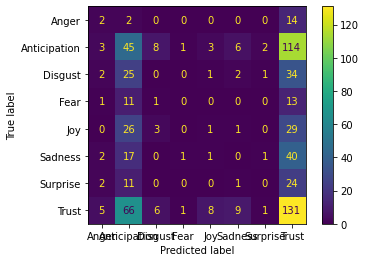

In [31]:
# logistic regression Classifier

# Preparing the model
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.20, random_state=42) # , stratify=Labels , random_state=99


# Display info about dataset distribution of classes 
from IPython.display import display
import pandas as pd

# print("train")
# arr = pd.DataFrame(np.unique(np.array(y_train), return_counts=True))
# display(arr)

# print("test")
# arr2 = pd.DataFrame(np.unique(np.array(y_test), return_counts=True))
# display(arr2)


# train and predict 
text_clf = pipe_clf.fit(X_train, y_train)
predictions = pipe_clf.predict(X_test)

# score = pipe_clf.score(X_train,y_train)
# print(score)


# print result 
print('accuracy (simple):', accuracy_score(y_test, predictions))
measures_info = metrics.classification_report(y_test, predictions, target_names=Labels, output_dict=True) #, labels=np.unique(predictions) 
info = pd.DataFrame(measures_info).transpose()
info = info.round(decimals=4).astype(object)

display(info)

# Confusion matrix 
# cnf_matrix = metrics.confusion_matrix(y_test, predictions)
# print(cnf_matrix)
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipe_clf, X_test, y_test)  
plt.show()

# print(pipe_clf.named_steps['vect'].vocabulary_) # prints vocabulary created by CountVectorizer
#print(pipe_clf.named_steps['vect'].stop_words_)


In [7]:
vectorizer = pipe_clf.named_steps['vect']

clf = pipe_clf.named_steps['clf']


#feature_names = vectorizer.get_feature_names()


imp_features = get_most_informative_features(clf, vectorizer, Labels, 30)


#print('len of coeffients: ', len(clf.coef_[0]), '\n', clf.coef_)

#print('len of intercepts: ', len(clf.intercept_), '\n', clf.intercept_)

print('imp_features\n', imp_features)

imp_features
 
Trust:

	-3.5066	diabet         		0.1737	spike          
	-2.4348	2              		0.1687	congrat        
	-2.2394	type           		0.1429	parent         
	-1.5879	wa             		0.1270	micronas       
	-1.2255	thi            		0.1114	inspir         
	-1.0153	t              		0.1056	tapeworm       
	-0.9093	year           		0.1037	excit          
	-0.8575	diet           		0.0966	genet          
	-0.8197	s              		0.0901	ketoacidosi    
	-0.8112	insulin        		0.0894	bathroom       
	-0.8030	m              		0.0834	half           
	-0.7372	eat            		0.0812	diagon         
	-0.6286	diagnos        		0.0812	gonna          
	-0.6095	weight         		0.0780	fairli         
	-0.5914	t2             		0.0725	honestli       

Disgust:

	-0.3239	hi             		5.2071	diabet         
	-0.2201	6              		3.2616	type           
	-0.1596	thank          		2.8507	2              
	-0.1491	wrote          		1.6116	s              
	-0.1353	year           		1.5772	t 

**TODO**
- Bag-of-words
- Bag-of-n-grams 
- Tf-Idf (is probably shit for our use case)

https://medium.com/analytics-vidhya/applying-text-classification-using-logistic-regression-a-comparison-between-bow-and-tf-idf-1f1ed1b83640

In [8]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.DataFrame(list(zip(X,y)))
df.rename(columns = {0:'text', 1:'label'}, inplace = True)
print(df.head())

train, test = train_test_split(df, test_size=0.3, random_state=42)
import nltk
from nltk.corpus import stopwords
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r.label]), axis=1)



import multiprocessing
cores = multiprocessing.cpu_count()


#building vocabulary
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, min_count=2, sample = 0, workers=cores)
model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])



                                                text    label
0   ...been on a low-carb diet my blood glucose h...    Trust
1  A major problem with the American diet is too ...  Disgust
2  Everybody knows that being fat leads to Type 2...    Trust
3  For example  this diet could help reduce prost...  Disgust
4  Hi everyone I have T2 diabetes and was diagnos...  Disgust


100%|██████████| 2370/2370 [00:00<?, ?it/s]


In [9]:
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 2370/2370 [00:00<?, ?it/s]


D:\Program Files\Anaconda\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Testing accuracy 0.25098425196850394
Testing F1 score: 0.21839903873460909


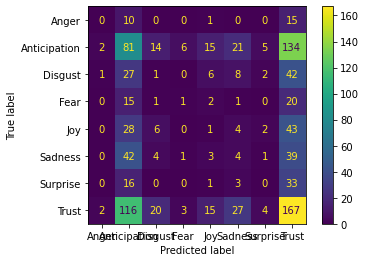

In [12]:
# building vector feature of classifier 
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words)) for doc in sents]) # , steps=20
    return targets, regressors


y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5, max_iter=10000)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
from sklearn.metrics import accuracy_score, f1_score
print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))


plot_confusion_matrix(logreg, X_test, y_test)  
plt.show()
